In [1]:
import cv2

# cv2는 이미지 색상을 BGR로 불러와서, RGB 색상으로 변환해주는 함수
def BGR2RGB(image):
    rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_img


### Normalization ###

# 컬러 이미지 Normalization 함수
def Normalization_Color(image):
    normalize_img = cv2.normalize(BGR2RGB(image), None, 0, 255, cv2.NORM_MINMAX) # RGB 이미지에 cv2.normalize() 적용
    shape = normalize_img.shape # 제대로 적용됐는지 이미지 shape 확인하기 위한 용도
    return normalize_img, shape

# 그레이 이미지 Normalization 함수
def Normalization_Gray(image):
    img = cv2.cvtColor(BGR2RGB(image), cv2.COLOR_RGB2GRAY) # RGB 색상을 Gray 색상으로 변환
    normalize_img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX) # Gray 이미지에 cv2.normalize() 적용 
    shape = normalize_img.shape # 제대로 적용됐는지 이미지 shape 확인하기 위한 용도
    return normalize_img, shape


### Histogram Equalization ###

# 컬러 이미지 HE 함수
def HE_Color(image):
    '''
    컬러 이미지에 HE 적용할 땐 밝기 정보와 색상 정보를 분리한 후, 밝기 정보인 Y에 대해서만 HE 수행함
    색상 정보는 변환되지 않아서 색감이 그대로 유지되고, 밝기 정보인 Y에 대해서만 명암비가 증가하게 됨
    '''
    img = cv2.cvtColor(BGR2RGB(image), cv2.COLOR_RGB2YCrCb) # RGB 색상을 YCrCb 색상으로 변환
    img_planes = cv2.split(img) # Y(밝기 정보), Cr & Cb(색상 정보)로 split
    img_planes_0 = cv2.equalizeHist(img_planes[0]) # 밝기 정보인 Y에 대해서만 cv2.equalizeHist() 적용
    merge_img = cv2.merge([img_planes_0, img_planes[1], img_planes[2]]) # 변환된 Y와 색상 정보 merge
    he_img = cv2.cvtColor(merge_img, cv2.COLOR_YCrCb2RGB) # YCrCb 색상을 RGB 색상으로 변환
    shape = he_img.shape # 제대로 적용됐는지 이미지 shape 확인하기 위한 용도
    return he_img, shape

# 그레이 이미지 HE 함수
def HE_Gray(image):
    img = cv2.cvtColor(BGR2RGB(image), cv2.COLOR_RGB2GRAY) # RGB 색상을 Gray 색상으로 변환
    he_img = cv2.equalizeHist(img) # Gray 이미지에 cv2.equalizeHist() 적용
    shape = he_img.shape # 제대로 적용됐는지 이미지 shape 확인하기 위한 용도
    return he_img, shape


In [2]:
import cv2
import os
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
def set_seed(seed_value=38):
    """Set seed for reproducibility."""
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(38)

In [4]:
class CustomTransform:
    def __call__(self, img):
        img = np.array(img)
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # NONE할 시 진행
        #img, _ = HE_Gray(img) # 
        img, _ = Normalization_Gray(img)
        return Image.fromarray(img)

data_transforms = {
    'train': transforms.Compose([
        CustomTransform(),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        CustomTransform(),
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
}

save_path = "C:/Users/rlckd/Downloads/BTS/resnet_gray_256_HE"

In [5]:
# 학습 데이터셋 불러오기
train_dataset = ImageFolder(root="C:/Users/rlckd/OneDrive/바탕 화면/remove_dataset2/train", transform=data_transforms['train'])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# 테스트 데이터셋 불러오기
test_dataset = ImageFolder(root="C:/Users/rlckd/OneDrive/바탕 화면/remove_dataset2/test", transform=data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
# 모델 정의
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer1.parameters():
    param.requires_grad = True
for param in model.layer2.parameters():
    param.requires_grad = True
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

# Fully connected layer도 학습시킵니다.
for param in model.fc.parameters():
    param.requires_grad = True

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

c:\Users\rlckd\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rlckd\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# 학습 및 검증
best_test_loss = 9999
num_epochs = 50

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # 검증
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)
    test_accuracy = test_corrects.double() / len(test_dataset)
    
    # 최고 성능 모델 저장
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), save_path)
        
    epoch_test_loss = test_loss / len(test_dataset)
    epoch_test_acc = test_corrects.double() / len(test_dataset)
    
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

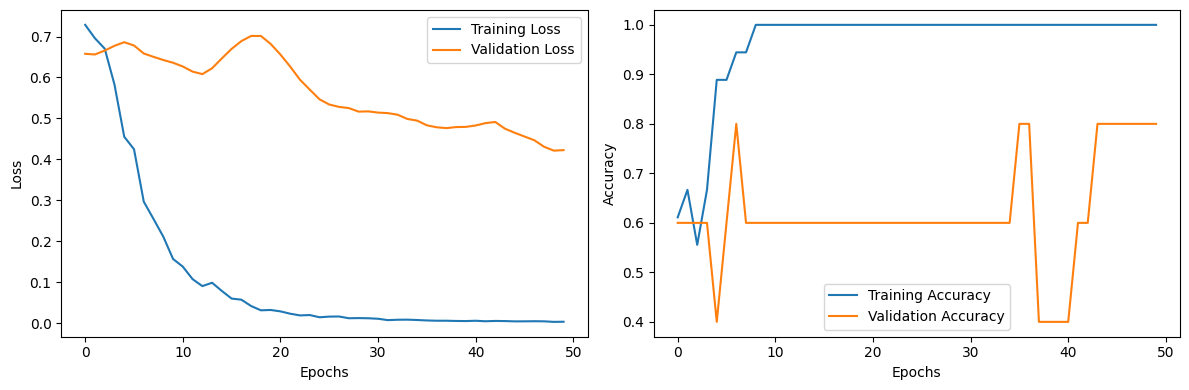

In [8]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

F1 Score: 0.8000
Accuracy: 0.8000
Precision: 0.6667
Recall: 1.0000
Confusion Matrix:
[[2 1]
 [0 2]]


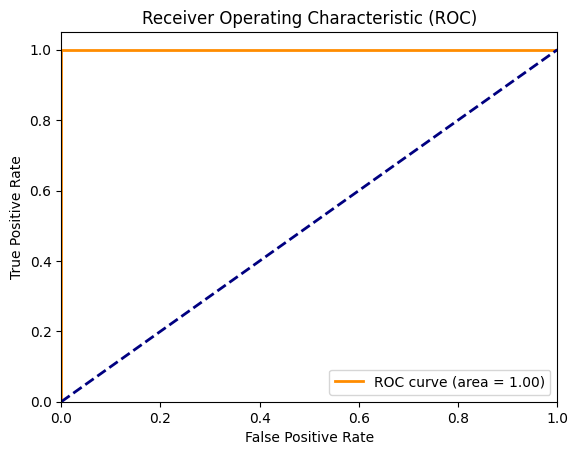

In [9]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc

# 테스트 데이터셋 불러오기
test_dataset = ImageFolder(root="C:/Users/rlckd/OneDrive/바탕 화면/remove_dataset2/test", transform=data_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

model.load_state_dict(torch.load(save_path))

# 모델을 평가 모드로 설정
model.eval()

all_labels = []
all_predictions = []
all_scores = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(preds.cpu().numpy())
        all_scores.extend(torch.nn.functional.softmax(outputs, dim=1)[:, 1].cpu().numpy())

# 성능 지표 계산
f1 = f1_score(all_labels, all_predictions)
acc = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
